In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.6'

In [2]:
!wget https://www.dropbox.com/s/6jpqhio95dptwi2/messi5.jpg

--2018-07-16 11:04:53--  https://www.dropbox.com/s/6jpqhio95dptwi2/messi5.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6jpqhio95dptwi2/messi5.jpg [following]
--2018-07-16 11:04:53--  https://www.dropbox.com/s/raw/6jpqhio95dptwi2/messi5.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc098def8c0c250611d6b5fd0272.dl.dropboxusercontent.com/cd/0/inline/ALevUmScGix1PxuTN0EcNzv4W47T3Jfw-C70lF_G_GsmctwIcFIMiDuUqFBsOZofE6RTLODq8dF-v7jX54pmHV4oZGazqcC7iAfvd2lKS-S90iIz7iBfxmgflr6R3lN6JOqT68g77t-qQwZKNK0wdftRqvvnjAsjPmATF9FJc5_EssYjo1K0x2i5N2C9EtRQhIA/file [following]
--2018-07-16 11:04:54--  https://uc098def8c0c250611d6b5fd0272.dl.dropboxusercontent.com/cd/0/inline/ALevUmScGix1PxuTN0EcNzv4W47T3Jfw-C70lF_G_GsmctwIcFIMiDuUq

# Deep Dream

アルゴリズムはCNNのフィルタ可視化手法とほぼ同じ。

フィルタの可視化ではCNNを逆向きに実行する。CNNの出力側の層において特定のフィルタの活性化を最大にするために、CNNへの入力に勾配上昇法を適応。

少しの違いは

- 特定のフィルタではなく、層全体の活性化を最大化。大量の特徴量が同時に可視化され、合成される。    
- 出発点はノイズが少し含まれた空の入力ではなく既存の画像で、既存の視覚パターンを補足し、画像の要素をやや審美的な方法で変更させる効果がある。    
- 入力画像は様々な尺度（オクターブ）で処理される。よって可視化の品質が改善される。



## Implementing Deep Dream in Keras

アーキテクチャが違えば学習する特徴も違ってくる。ここではInception V3を使う。

In [3]:
from keras.applications import inception_v3
from keras import backend as K

# 訓練関連の演算を無効にする
K.set_learning_phase(0)

# 学習済みモデルの読み込み
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

87916544/87910968 [==============================] - 3s 0us/step


In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
# 層の名前を係数にマッピングするディレクトリ。
# mixedホゲホゲは最大化の対象となる損失値にその層の活性化がどれくらい貢献するかを表す。
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

損失値を計算する。勾配上昇法を実行する過程で最大化の対象となるのは損失値。フィルタ可視化では特定の層での特定のフィルタの最大化を試みた。ここではいくつかの層で全てのフィルタの活性化の最大化をする。（活性化のL2ノルムの荷重和を最大化する）

損失値を保持するテンソルを定義。この損失値は、上のリストで指定されている層の活性化のL2ノルムの荷重和。

In [4]:
# 層の名前のインスタンスにマッピングするディクショナリ
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# loss定義
loss = K.variable(0.)
#　layer_contributionsはレイヤー重要度の重み付け
for layer_name in layer_contributions:
    #レイヤーのlossに特徴のL2ノルムを追加する
    coeff = layer_contributions[layer_name]
    #層の出力
    activation = layer_dict[layer_name].output
    #prodは積。castでfloat32に変換。shapeはshapeを返す。
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    #非境界ピクセルのみをlossに適用することで、周辺効果を回避
    #squareは平行根。
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

勾配上昇ほうのプロセスを設定する。

In [0]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

最後にDeepDreamのアルゴリズムを定義する。画像を処理する尺度のリストを定義。尺度はオクターブとも呼ばれ、1つ前の尺度より1.4倍(40%)ずつ大きくなる。小さい画像から徐々に大きくする。

![deep dream process](https://s3.amazonaws.com/book.keras.io/img/ch8/deepdream_process.png)


Then, for each successive scale, from the smallest to the largest, we run gradient ascent to maximize the loss we have previously defined, 
at that scale. After each gradient ascent run, we upscale the resulting image by 40%.

To avoid losing a lot of image detail after each successive upscaling (resulting in increasingly blurry or pixelated images), we leverage a 
simple trick: after each upscaling, we reinject the lost details back into the image, which is possible since we know what the original 
image should look like at the larger scale. Given a small image S and a larger image size L, we can compute the difference between the 
original image (assumed larger than L) resized to size L and the original resized to size S -- this difference quantifies the details lost 
when going from S to L.

The code above below leverages the following straightforward auxiliary Numpy functions, which all do just as their name suggests. They 
require to have SciPy installed.

In [0]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [9]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use
base_image_path = './messi5.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Processing image shape (174, 279)
...Loss value at 0 : 1.5335319
...Loss value at 1 : 2.0995572
...Loss value at 2 : 2.775989
...Loss value at 3 : 3.501143
...Loss value at 4 : 4.1176896
...Loss value at 5 : 4.7787614
...Loss value at 6 : 5.321202
...Loss value at 7 : 5.9697804
...Loss value at 8 : 6.461107
...Loss value at 9 : 6.9718776
...Loss value at 10 : 7.3839307
...Loss value at 11 : 7.833314
...Loss value at 12 : 8.345046
...Loss value at 13 : 8.800281
...Loss value at 14 : 9.195658
...Loss value at 15 : 9.58703
Processing image shape (244, 391)
...Loss value at 0 : 2.7822895
...Loss value at 1 : 4.047642
...Loss value at 2 : 5.181824
...Loss value at 3 : 6.1569147
...Loss value at 4 : 7.0087047
...Loss value at 5 : 7.7932777
...Loss value at 6 : 8.546547
...Loss value at 7 : 9.251889
...Loss value at 8 : 9.885957
Processing image shape (342, 548)
...Loss value at 0 : 3.1083446
...Loss value at 1 : 4.381794
...Loss value at 2 : 5.6028514
...Loss value at 3 : 6.677712
...Loss va

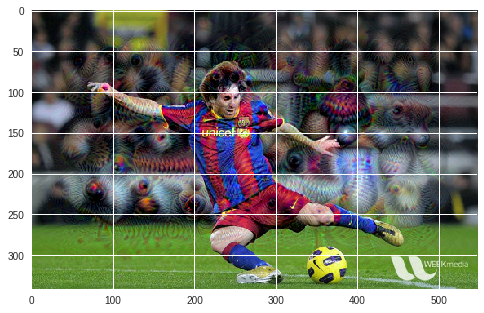

In [10]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

損失の計算に使用する層を調整しながら、何ができるようになったのか確認してください。
